## Interface height vs layer thickness gradients

In models with large scale bottom slope changes the bottom layer thickness ends up incorporating this information in it. While this bottom slope probably impacts the eddy fluxes, it does not seem to be the case that this has a first order effect. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-07 01:05:59.954265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 01:05:59.954292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 01:05:59.955520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [19]:
# Experiment
experiment_config= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        #'dedx_middle_widened',
                                        #'dedy_middle_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
                    'sim_data_time_range': slice(0, 1200), 
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 8*9 + 1, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt_P2L'
                    
            }

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

In [5]:

#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['sim_data_time_range'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.18304 gb into memory.
load took: 6.8603 seconds
Will load : 0.018304 gb into memory.
load took: 1.5896 seconds


In [6]:
batch_xr = ML_DT_train.ml_batches[0]

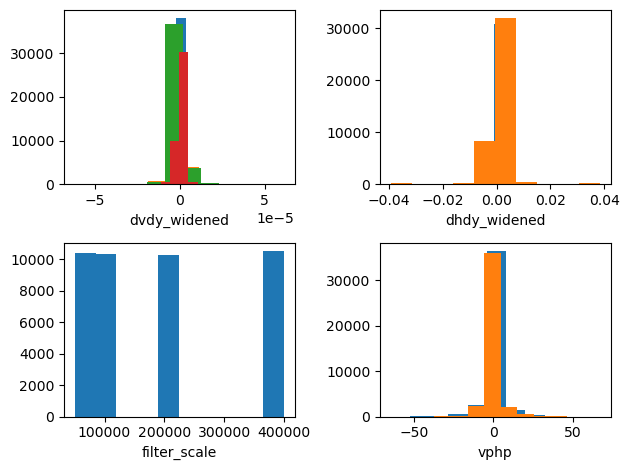

In [7]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [8]:
batch_xr.std()

<xarray.Dataset> Size: 64B
Dimensions:       ()
Data variables:
    dudx_widened  float64 8B 1.868e-06
    dvdx_widened  float64 8B 3.359e-06
    dudy_widened  float64 8B 3.209e-06
    dvdy_widened  float64 8B 1.858e-06
    dhdx_widened  float64 8B 0.000782
    dhdy_widened  float64 8B 0.004339
    filter_scale  float64 8B 1.347e+05
    uphp          float32 4B 5.408
    vphp          float32 4B 4.958

In [9]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dedx_middle_widened': ([], 1e-3),
    'dedy_middle_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [10]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [12]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (41513, 7)
Output (y) batch shape: (41513, 2)


In [13]:
num_in = batch_out['X'].shape[-1]
num_in

7

In [15]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [16]:
ANN_model.count_parameters()

1694


In [17]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [18]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  1.3910581227895376 , Test loss: 1.0491079330444335
At epoch 3. Train loss :  0.6048794388771057 , Test loss: 0.5788740754127503
At epoch 5. Train loss :  0.4151417468045209 , Test loss: 0.4200162410736084
At epoch 7. Train loss :  0.34100568133431514 , Test loss: 0.3594436883926392
At epoch 9. Train loss :  0.30496678481230866 , Test loss: 0.3284239947795868
At epoch 11. Train loss :  0.2834185716268179 , Test loss: 0.30658923983573916
At epoch 13. Train loss :  0.2679216620084402 , Test loss: 0.29350280165672304
At epoch 15. Train loss :  0.2578075226094272 , Test loss: 0.28053413033485414
At epoch 17. Train loss :  0.2504888454804549 , Test loss: 0.27336116433143615
At epoch 19. Train loss :  0.24572040905823578 , Test loss: 0.2678378939628601
At epoch 21. Train loss :  0.24064464746294795 , Test loss: 0.26466104984283445
At epoch 23. Train loss :  0.23634052115517692 , Test loss: 0.261995267868042
At epoch 25. Train loss :  0.23341775826505712 , Test loss: 

Clearly and obviously this loss is a function of the normalization that is used. 

In [20]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [21]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])


In [22]:
# Spin up 
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

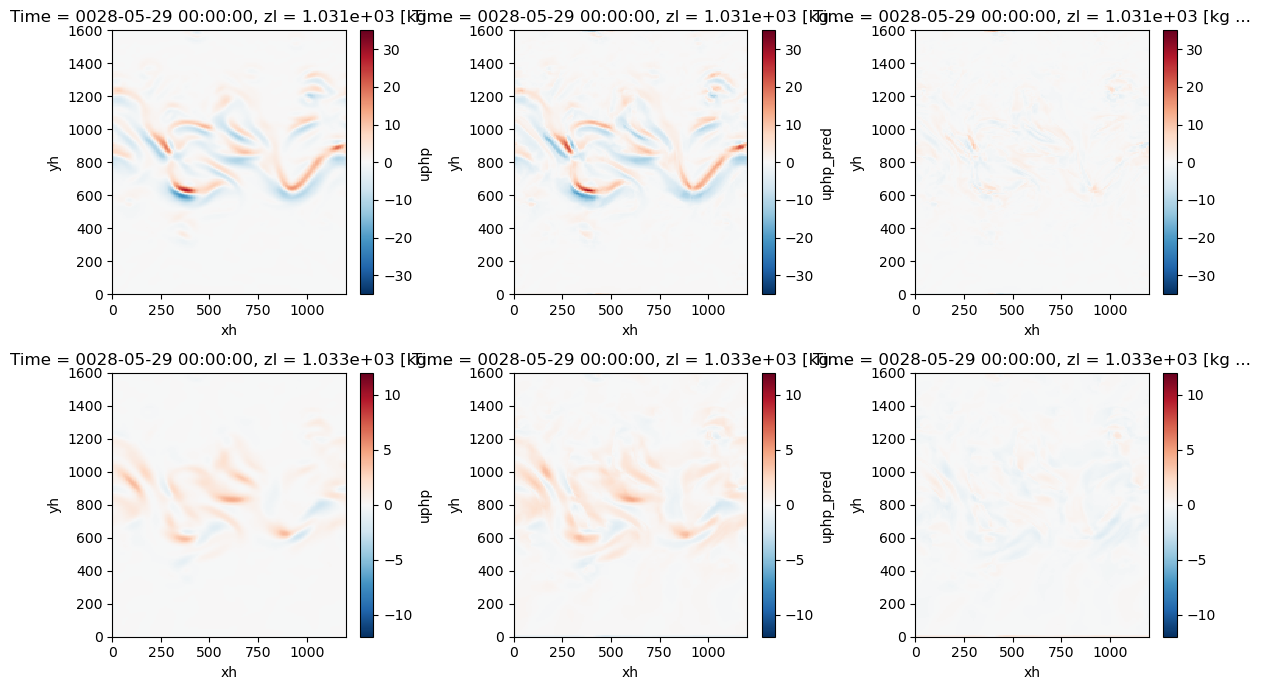

In [23]:
exp = experiment_config['simulation_names'][0]
scale = '50'

plt.figure(figsize=(12, 7))

vmin=-35
zl_choice = 0

plt.subplot(231)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(232)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred'].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(233)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred']).isel(Time=0, zl=0).plot(vmin=vmin)


vmin=-12 
zl_choice = 1

plt.subplot(234)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(235)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(236)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.tight_layout()

In [26]:
# Pick some region away from boundaries to do that stats 

In [24]:
test_eval.calc_time_hor_space_metrics(yh_region=slice(200, 1400), dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp', yh_region=slice(200, 1400), dims=['Time','xh','yh'])

In [25]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', R2 for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+', R2 for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

P2L 50, R2 for uphp is [0.92079608 0.76656118]
P2L 50, R2 for vphp is [0.89682021 0.84963041]
P2L 100, R2 for uphp is [0.94882439 0.85434176]
P2L 100, R2 for vphp is [0.92895874 0.92145178]
P2L 200, R2 for uphp is [0.92042691 0.70604613]
P2L 200, R2 for vphp is [0.89446723 0.83308405]
P2L 400, R2 for uphp is [0.83730705 0.60180192]
P2L 400, R2 for vphp is [0.7633095  0.69870569]


In [27]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values))
        print(exp+' '+scale+', corr for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values))

P2L 50, corr for uphp is [0.96296118 0.90117944]
P2L 50, corr for vphp is [0.95161623 0.92545015]
P2L 100, corr for uphp is [0.97457361 0.922535  ]
P2L 100, corr for vphp is [0.96374629 0.95428804]
P2L 200, corr for uphp is [0.9596605  0.83559611]
P2L 200, corr for vphp is [0.94322579 0.89689504]
P2L 400, corr for uphp is [0.91692108 0.77383817]
P2L 400, corr for vphp is [0.84361017 0.76014022]


In [34]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', mse for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values))
        print(exp+' '+scale+', mse for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values))

P2L 50, mse for uphp is [1.59299473 0.14538398]
P2L 50, mse for vphp is [2.50901759 0.17926466]
P2L 100, mse for uphp is [3.74640426 0.41837588]
P2L 100, mse for vphp is [4.68565387 0.49923747]
P2L 200, mse for uphp is [4.03560279 1.341113  ]
P2L 200, mse for vphp is [5.16409846 1.68405452]
P2L 400, mse for uphp is [6.13205017 2.905034  ]
P2L 400, mse for vphp is [7.20722295 5.59359156]


Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 